# Preparação

## Fontes de informação


*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

## Importação de módulos e leitura de dados

In [1]:
# instalação de módulos
!pip install squarify

In [2]:
# importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import squarify
from ipywidgets import interact

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

In [4]:
# Designações dos cursos e departamentos
LISTA_DEPTS = docentes['Departamento'].unique()
LISTA_CURSOS = alunos_per_curso.index.unique()

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2.Âº TriÃ©nio', 'Assistente', 'Equiparado Assistente 2Âº TriÃ©nio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto

## Definição de funções

In [6]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
    idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
    aposentados = df[idade > idade_reforma]
    ativos = df.drop(index=aposentados.index)
    return aposentados, ativos

In [7]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].count()
  s = s.loc[(slice(None), categoria)]
  s = s.droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

# Exploração de dados

## Elementos constantes (para simplificar)

In [8]:
# Elementos constantes (time independent features)
# Simplificação: constância do número de alunos e das horas de contacto 
horas_per_dept = horas.sum()
horas_per_curso = horas.sum(axis=1)

pesos_dept_per_curso = horas.T / horas_per_curso
pesos_curso_per_dept = horas / horas_per_dept
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_curso = alunos_per_curso['Alunos']

### Fotografia do ISEL hoje (2022)

In [9]:
# Eficiência relativa dos departamentos/cursos
ratio_aluno_hora_ISEL = alunos_per_curso.sum() / horas_per_curso.sum()
eff_per_dept = 100 * alunos_per_dept / horas_per_dept / ratio_aluno_hora_ISEL
eff_per_curso = 100 * alunos_per_curso / horas_per_curso / ratio_aluno_hora_ISEL
eff_per_curso.dropna(inplace=True)

Text(0.5, 0.98, 'Eficiência relativa de cada departamento')

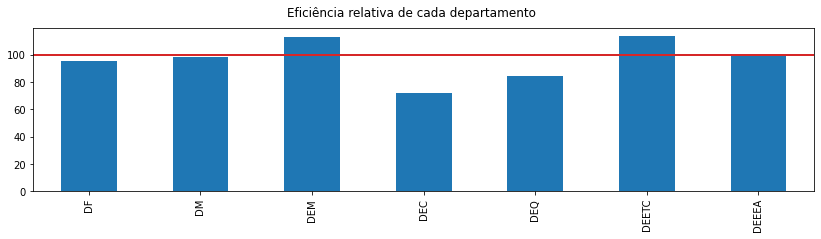

In [10]:
# Figura com eficiência relativa de cada departamento
plt.figure(1, figsize=(14, 3))
eff_per_dept.plot.bar()
plt.axhline(y=100,linewidth=2, color='#d62728')
plt.suptitle('Eficiência relativa de cada departamento')

Text(0.5, 0.98, 'Eficiência relativa de cada curso')

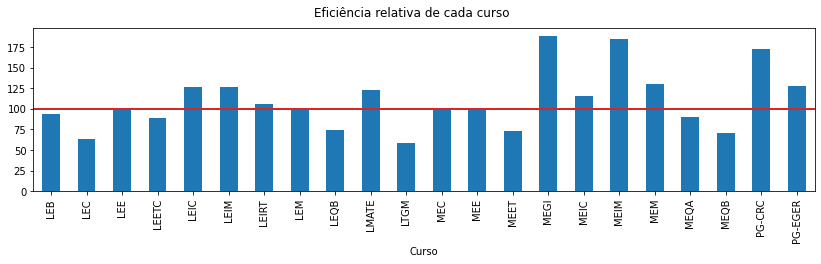

In [11]:
# Figura com eficiência relativa de cada curso
plt.figure(1, figsize=(14, 3))
eff_per_curso.plot.bar()
plt.axhline(y=100,linewidth=2, color='#d62728')
plt.suptitle('Eficiência relativa de cada curso')

Text(0.5, 0.98, 'Recursos docentes por curso')

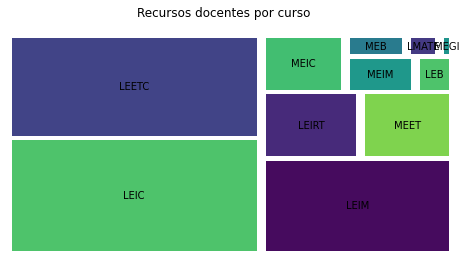

In [12]:
# Treemap com horas de cada departamento
plt.figure(1, figsize=(8, 4))
s = horas['DEETC'].copy()
s.sort_values(ascending=False, inplace=True)
s = s[s > 0]
squarify.plot(sizes=s.values, label=s.index, pad=True)
plt.axis('off')
plt.suptitle('Recursos docentes por curso')

Text(0.5, 0.98, 'Alunos por curso (licenciaturas)')

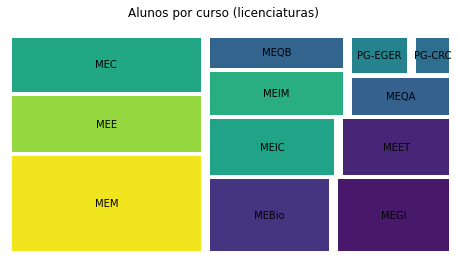

In [13]:
# Treemap com alunos por cursos
plt.figure(1, figsize=(8, 4))
s = alunos_per_curso[11:].copy()
s.sort_values(ascending=False, inplace=True)
s = s[s > 0]
squarify.plot(sizes=s.values, label=s.index, pad=True)
plt.axis('off')
plt.suptitle('Alunos por curso (licenciaturas)')

## Elementos que variam no tempo

In [14]:
ANO = 2022
IDADE_REFORMA = 67
aposentados, ativos = aposentados_e_ativos(docentes, ANO, IDADE_REFORMA)

In [15]:
# Rácio Alunos / ETI
alunos_per_eti_isel = alunos_per_curso.sum() / ativos['ETI'].sum()
eti_per_dept = ativos.groupby(['Departamento'])['ETI'].sum()
alunos_per_eti_dept = alunos_per_dept / eti_per_dept
alunos_per_eti_dept.dropna(inplace=True)

### ETIs por departamento

Text(0.5, 0.98, 'Total de ETIs por departamento')

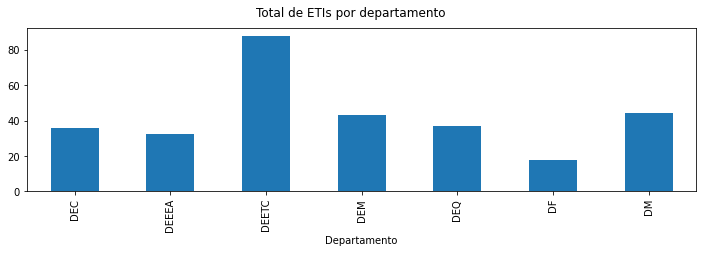

In [16]:
# Figura com ETI por departamento
plt.figure(1, figsize=(12, 3))
eti_per_dept.plot.bar()
plt.suptitle('Total de ETIs por departamento')

Fazer figura com os ETIs a diminuir com os anos

Text(0.5, 0.98, 'Ritmo de aposentações por departamento')

<Figure size 864x216 with 0 Axes>

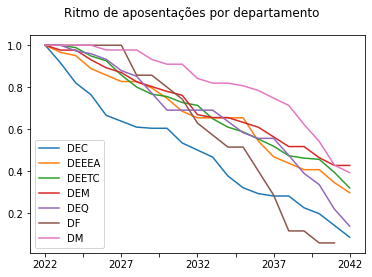

In [17]:
# Ritmo de aposentações
ano_inicial = 2022
ano_final = ano_inicial + 20
df = pd.DataFrame()
for ano in range(ano_inicial, ano_final+1):
  ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  s = at.groupby(['Departamento'])['ETI'].sum()
  s.name = str(ano)
  df = df.append(s)

percentage = df /df.loc[str(ano_inicial)]
plt.figure(1, figsize=(12, 3))
percentage.plot()
plt.suptitle('Ritmo de aposentações por departamento')

### Rácio Alunos por ETI

Text(0.5, 0.98, 'Alunos / ETI')

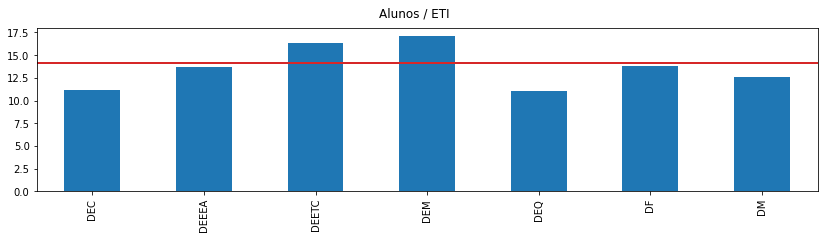

In [18]:
# Figura com rácio Alunos/ETI por departamento 
plt.figure(1, figsize=(14, 3))
alunos_per_eti_dept.plot.bar()
plt.axhline(y=alunos_per_eti_isel,linewidth=2, color='#d62728')
plt.suptitle('Alunos / ETI')

### ETIs em falta



In [19]:
# VIANA (Valor Ideal Atendendo ao Número de Alunos)
alunos_per_eti_ideal = alunos_per_eti_isel
viana = alunos_per_dept / alunos_per_eti_ideal
fana = viana - eti_per_dept

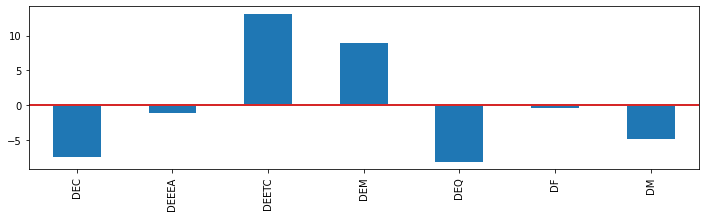

In [20]:
plt.figure(1, figsize=(12, 3))
fana.plot.bar()
plt.axhline(y=0,linewidth=2, color='#d62728')

### Docentes por categoria

In [21]:
categoria = cat_prof_coord

Text(0.5, 0.98, 'Ritmo de aposentações na categoria por departamento')

<Figure size 864x216 with 0 Axes>

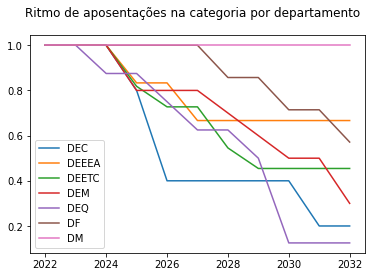

In [22]:
# Ritmo de aposentações na categoria
ano_inicial = 2022
ano_final = ano_inicial + 10
df = pd.DataFrame()
for ano in range(ano_inicial, ano_final+1):
  ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  s = docentes_per_categoria(at, categoria)
  s.name = str(ano)
  df = df.append(s)

percentage = df /df.loc[str(ano_inicial)]
plt.figure(1, figsize=(12, 3))
percentage.plot()
plt.suptitle('Ritmo de aposentações na categoria por departamento')

Text(0.5, 0.98, "['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']")

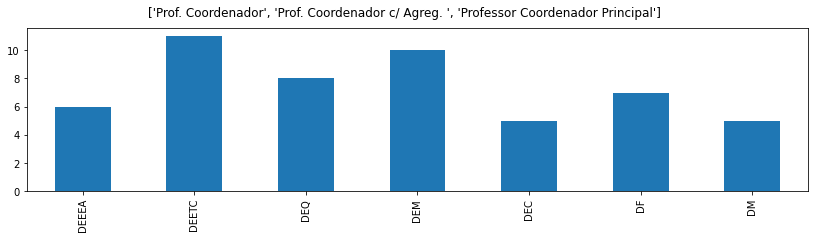

In [23]:
plt.figure(1, figsize=(14, 3))
docentes_per_categoria(ativos, categoria).plot.bar()
plt.suptitle(f'{categoria}')

# Equalização de recursos docentes

## Definir o rácio que se pretende uniformizar

In [24]:
ratio_numerator = docentes_per_categoria(ativos, cat_prof_coord)

In [25]:
ratio_denominator_1 = docentes_per_categoria(ativos, cat_quadro)
ratio_denominator_2 = docentes_per_categoria(ativos, cat_quadro) + \
          0.3*docentes_per_categoria(ativos, cat_convidado)
ratio_denominator_3 = docentes_per_categoria(ativos, cat_quadro) + \
          0.3*docentes_per_categoria(ativos, cat_convidado) + fana

In [26]:
ratio_denominator = ratio_denominator_1

In [27]:
ratio = ratio_numerator / ratio_denominator

## Bolo a distribuir

In [28]:
cake = 16
target = 0.25

## Critérios de distribuição

In [29]:
def how_many_to_target(target):
  s = ratio_denominator * target - ratio_numerator
  s.clip(lower=0, inplace=True)
  return s

In [30]:
# METHOD 1 - Linear mapping
def linear_map_to_cake(target, cake):
  s = how_many_to_target(target)
  return s / s.sum() * cake 

In [31]:
# METHOD 2 - D'Hondt
def method_hondt_to_cake(target, cake):
  s = how_many_to_target(target)
  list_of_series = [s/i for i in range(1, cake+1)]
  df = pd.concat(list_of_series, axis=1)
  vals = np.sort(np.ravel(df.to_numpy(copy=True)))[-1::-1]
  df = df >= vals[cake-1]
  return df.sum(axis=1)

In [32]:
# METHOD 3 - Greedy iteration
def one_at_a_time(cake):
  numerator = ratio_numerator
  denominator = ratio_denominator
  s = pd.Series(data=0, index=LISTA_DEPTS)
  for i in range(cake):
    ratio = numerator / denominator
    ix = ratio.idxmin()
    s[ix] += 1
    numerator[ix] += 1
  return s

In [33]:
linear_map_to_cake(target, cake)

DEEEA    0.507937
DEETC    7.619048
DEQ      0.507937
DEM      0.000000
DEC      2.793651
DF       0.000000
DM       4.571429
Name: ETI, dtype: float64

In [34]:
method_hondt_to_cake(target, cake)

DEEEA    0
DEETC    8
DEQ      0
DEM      0
DEC      3
DF       0
DM       5
dtype: int64

In [35]:
one_at_a_time(cake)

DEEEA    1
DEETC    7
DEQ      1
DEM      0
DEC      3
DF       0
DM       4
dtype: int64

# Testes

In [36]:
plt.figure(1, figsize=(13, 4))
def func(ano):
  IDADE_REFORMA = 70
  aposentados, ativos = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  categorias = ['Professor Adjunto', 'Prof. Coordenador']
  subset = ativos.groupby(['Departamento', 'Categoria'])['ETI'].count()
  subset = subset.loc[(slice(None), categorias)]
  subset = subset.droplevel(level=1)
  subset = subset.groupby(subset.index).sum()
  subset.plot.bar()

<Figure size 936x288 with 0 Axes>

In [37]:
interact(func, ano=(2022, 2042))        

interactive(children=(IntSlider(value=2032, description='ano', max=2042, min=2022), Output()), _dom_classes=('…

<function __main__.func>